# Pandas Basics: Discovery → Cleaning → Quick Transforms

**Goal:** practice fast exploratory wrangling on a messy tabular dataset using Pandas.

**You’ll do:**
- Inspect structure and types
- Quantify missingness
- Handle missing values (drop / fill / interpolate)
- Lightweight transforms (casting, renaming, grouping, joining)
- Quick validation & export

## 1. Setup
---
**Goal:** Prepare your environment and load a dataset into Pandas.

**Steps:**
1. Import libraries: `pandas as pd`, `numpy as np`
2. Load your CSV into a DataFrame (`df`)

In [ ]:
import os, sys, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set paths
ROOT_ = os.getcwd()
DATA_  = os.path.join(ROOT_, "data")

# Obtain all CSV file paths in the data directory
csv_paths = glob.glob(os.path.join(DATA_, "*.csv*"))
assert len(csv_paths) > 0, f"No CSV files found in {DATA_}"

> 💡 "Data should be transformed as far upstream as possible, and as far downstream as necessary" - Matthew Roche, Microsoft

> Use `pd.read_csv(..., dtype=..., parse_dates=...)` to enforce schema at load time.



In [ ]:
# Load non-comma delimited data
data_name = "semicolon"
path = [path for path in csv_paths if data_name in path][0]
df_semicolon_delim = pd.read_csv(path)
print(df_semicolon_delim.head())

In [ ]:
# Load compressed data
data_name = "compressed"
path = [path for path in csv_paths if data_name in path][0]
df_compressed = pd.read_csv(path)   # Works because compression='infer' by default
print(df_compressed.head())

In [ ]:
# Load encoded data
data_name = "latin1"
path = [path for path in csv_paths if data_name in path][0]
df_encoded = pd.read_csv(path)
print(df_encoded.head())

In [ ]:
# Load data with metadata rows
data_name = "metadata"
path = [path for path in csv_paths if data_name in path][0]
df_metadata = pd.read_csv(path, skiprows=2, header=0)
print(df_metadata.head())

In [ ]:
# Load European date data
data_name = "dates1"
path = [path for path in csv_paths if data_name in path][0]
df_dayfirst = pd.read_csv(path)
print(df_dayfirst.head())

In [ ]:
# Load EU/US date data
data_name = "dates2"
path = [path for path in csv_paths if data_name in path][0]
df_dayfirst = pd.read_csv(path)
print(df_dayfirst.head(10))

# How do you decide if a number <= 12 is a month or a day?
# Without another column identifying region or prior information, we can't parse these correctly on read.

## 2. Discovery & Data Exploration
---
**Goal:** Get a first impression of the dataset’s structure and contents.**

**Core Functions:**
- `df.head()`, `df.tail()` → peek at rows
- `df.sample(5)` → random check
- `df.shape`, `df.dtypes`, `df.columns` → structure overview
- `df.info()` → column types + non-null counts
- `df.describe(include='all')` → quick summary (numeric + categorical)
- `df['col'].value_counts(dropna=False)` → frequency counts

> 📝 *Exercise*: Identify 3 columns that look suspicious (weird types, strange ranges, inconsistent categories).

In [103]:
"""Generate messy dataset for workshop"""
import numpy as np
import pandas as pd

# Set random seed for reproducibility
rng = np.random.default_rng(42)

# Generate a dataset with 500 rows and 5 features
n = 500
age = rng.integers(15, 90, size=n).astype(float)  # numeric with some missing
income = rng.normal(50000, 15000, size=n)         # numeric with outliers
score = rng.uniform(0, 100, size=n)               # uniform, noise
signup_date = pd.date_range("2020-01-01", periods=n, freq="D")  # datetime
category = rng.choice(["A", "B", "C", None], size=n, p=[0.3, 0.3, 0.3, 0.1])  # categorical with NaNs

# Introduce missing values in age and income
age[rng.choice(n, 30, replace=False)] = np.nan
income[rng.choice(n, 20, replace=False)] = np.nan

# Add some extreme outliers in income
income[rng.choice(n, 5, replace=False)] = rng.normal(200000, 10000, size=5)

# Slightly corrupt score with negative and >100 values
score[rng.choice(n, 10, replace=False)] = rng.choice([-10, 150], size=10)

# Make signup_date strings with mixed separators
date_formats = ["%Y-%m-%d", "%Y/%m/%d", "%Y_%m_%d"]
signup_date_str = []
for i, dt in enumerate(signup_date):
    fmt = date_formats[i % len(date_formats)]
    signup_date_str.append(dt.strftime(fmt))

# Generate first and last names with inconsistencies
first_names = rng.choice(
    ["john", "ALICE", "Bob ", " mary", "N/A", None, "Eve", "steve", " Anna "],
    size=n
)
last_names = rng.choice(
    ["SMITH", "jones", "   DOE", "Brown", None, "Miller", "Wilson", "LEE", "N/A"],
    size=n
)

# Generate time column with constant format (e.g., "HH:MM")
times = pd.date_range("08:00", periods=n, freq="min")
time_str = [t.strftime("%H:%M") for t in times]

# Assemble DataFrame
df = pd.DataFrame({
    "first_name": first_names,
    "last_name": last_names,
    "age": age,
    "income": income,
    "score": score,
    "signup_date": signup_date_str,
    "signup_time": time_str,
    "category": category
})

# Introduce some duplicate rows
df = pd.concat([df, df.sample(10, random_state=42)], ignore_index=True)

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save to CSV
df.to_csv(f"{DATA_}/trashy_dataset.csv", index=False)


In [104]:
# Load raw data
df_trashy_dataset = pd.read_csv(f"{DATA_}/trashy_dataset.csv")

# Print head and tail of the DataFrame
print(f"[DataFrame Head]\n")
print(df_trashy_dataset.head(10))

print(f"\n[DataFrame Tail]\n")
print(df_trashy_dataset.tail(10))

# Obtain a random sample from the DataFrame
print(f"\n[Random Sample of n Rows]\n")
print(df_trashy_dataset.sample(10))

[DataFrame Head]

  first_name last_name   age        income      score signup_date signup_time  \
0        NaN    Wilson  36.0  66920.282860  10.740296  2021-04-25       16:00   
1       Bob        NaN  36.0  54711.158358   0.106747  2021_03_25       15:29   
2      ALICE     Brown  73.0  26547.830782  61.048507  2021/04/20       15:55   
3      Anna        LEE  47.0  55240.259338   4.945914  2021_03_10       15:14   
4      steve     jones  16.0  58070.516599  67.226443  2021_01_03       14:08   
5       mary     SMITH  18.0  54439.909845  59.571377  2020/02/25       08:55   
6       mary       DOE  61.0  38516.970839  25.780841  2020/11/18       13:22   
7       mary    Miller   NaN  39538.642650  68.258160  2020/03/17       09:16   
8       Bob        NaN  74.0  19051.425848  88.757109  2020_04_14       09:44   
9       john       NaN  85.0  53531.725525  27.063215  2020_12_13       13:47   

  category  
0        A  
1        A  
2        C  
3      NaN  
4        C  
5        B  

In [105]:
df_trashy_dataset = pd.read_csv(
    f"{DATA_}/trashy_dataset.csv",

    # Handle NA values
    na_values=["N/A", "NA", "None"],   # Treat these as NaN
    keep_default_na=True,                  # Also keep pandas' default NA list

    # Strip extra spaces
    skipinitialspace=True,                 # strips spaces after delimiter

    # Handle duplicate header rows or bad lines
    on_bad_lines="skip",                   # skip malformed lines

    # Dtypes (optional, can enforce)
    dtype={"age": "float", "income": "float", "score": "float"},
)

# Move 'signup_datetime' to the second to last column
cols = df_trashy_dataset.columns.tolist()
df_trashy_dataset = df_trashy_dataset[cols]

# Print head and tail of the DataFrame
print(f"[DataFrame Head]\n")
print(df_trashy_dataset.head(10))

print(f"\n[DataFrame Tail]\n")
print(df_trashy_dataset.tail(10))

# Obtain a random sample from the DataFrame
print(f"\n[Random Sample of n Rows]\n")
print(df_trashy_dataset.sample(10))

[DataFrame Head]

  first_name last_name   age        income      score signup_date signup_time  \
0        NaN    Wilson  36.0  66920.282860  10.740296  2021-04-25       16:00   
1       Bob        NaN  36.0  54711.158358   0.106747  2021_03_25       15:29   
2      ALICE     Brown  73.0  26547.830782  61.048507  2021/04/20       15:55   
3      Anna        LEE  47.0  55240.259338   4.945914  2021_03_10       15:14   
4      steve     jones  16.0  58070.516599  67.226443  2021_01_03       14:08   
5       mary     SMITH  18.0  54439.909845  59.571377  2020/02/25       08:55   
6       mary       DOE  61.0  38516.970839  25.780841  2020/11/18       13:22   
7       mary    Miller   NaN  39538.642650  68.258160  2020/03/17       09:16   
8       Bob        NaN  74.0  19051.425848  88.757109  2020_04_14       09:44   
9       john       NaN  85.0  53531.725525  27.063215  2020_12_13       13:47   

  category  
0        A  
1        A  
2        C  
3      NaN  
4        C  
5        B  

In [106]:
# View DataFrame shape, columns, and data types
print(f"\nDataFrame Shape: {df_trashy_dataset.shape}")
print(f"DataFrame Columns: {df_trashy_dataset.columns.tolist()}\n")
print(f"DataFrame Dtypes:\n {df_trashy_dataset.dtypes}")


DataFrame Shape: (510, 8)
DataFrame Columns: ['first_name', 'last_name', 'age', 'income', 'score', 'signup_date', 'signup_time', 'category']

DataFrame Dtypes:
 first_name      object
last_name       object
age            float64
income         float64
score          float64
signup_date     object
signup_time     object
category        object
dtype: object


In [107]:
# Print DataFrame info to see data types and non-null counts
print(f"\n[DataFrame Info]\n")
print(df_trashy_dataset.info())


[DataFrame Info]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   first_name   390 non-null    object 
 1   last_name    401 non-null    object 
 2   age          480 non-null    float64
 3   income       490 non-null    float64
 4   score        510 non-null    float64
 5   signup_date  510 non-null    object 
 6   signup_time  510 non-null    object 
 7   category     449 non-null    object 
dtypes: float64(3), object(5)
memory usage: 32.0+ KB
None


In [108]:
# Generate summary statistics for all columns:
# - For numeric columns:            count, mean, std, min, quartiles (25%, 50%, 75%), max
# - For object/categorical columns: count, unique, top (most frequent), freq (frequency of top)
# - For datetime columns:           count, unique, top, freq, first, last
df_trashy_dataset.sort_values('signup_date').describe(include='all')

,first_name,last_name,age,income,score,signup_date,signup_time,category
count,390,401,480.000000,490.000000,510.000000,510,510,449
unique,7,7,NaN,NaN,NaN,500,500,3
top,Bob,DOE,NaN,NaN,NaN,2020/12/27,14:01,B
freq,62,69,NaN,NaN,NaN,2,2,156
mean,NaN,NaN,52.712500,51436.949471,50.696396,NaN,NaN,NaN
std,NaN,NaN,21.531951,21355.627530,31.370096,NaN,NaN,NaN
min,NaN,NaN,15.000000,5532.067432,-10.000000,NaN,NaN,NaN
25%,NaN,NaN,35.000000,39996.109592,22.341858,NaN,NaN,NaN
50%,NaN,NaN,52.000000,50806.316997,49.246476,NaN,NaN,NaN
75%,NaN,NaN,72.000000,60437.522114,77.046563,NaN,NaN,NaN



Unique values in 'category' column:
income
NaN             20
62419.822652     2
19051.425848     2
46313.577500     2
69116.708254     2
                ..
39176.629497     1
14086.095426     1
61091.190085     1
62698.759788     1
56208.354281     1
Name: count, Length: 481, dtype: int64


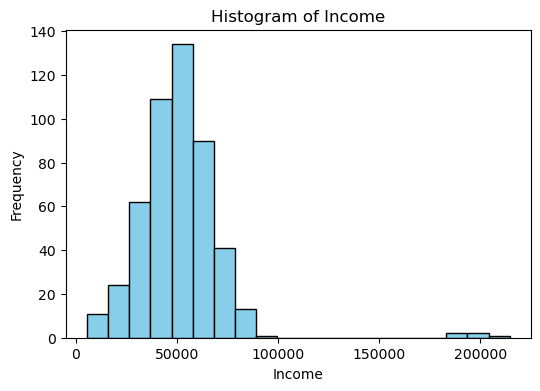

In [109]:
# Print unique values for a specific column and its value counts
column = 'income'
print(f"\nUnique values in 'category' column:\n{df_trashy_dataset[column].value_counts(dropna=False)}")

# Visualized
value_counts = df_trashy_dataset[column].value_counts(dropna=False)
if df_trashy_dataset[column].dtype == 'object':
    plt.figure(figsize=(6, 4))
    ax = value_counts.plot(kind='barh')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Value Counts for Category Column')
    plt.show()
else:
    plt.figure(figsize=(6, 4))
    ax = df_trashy_dataset[column].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
    plt.xlabel(column.capitalize())
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column.capitalize()}')
    plt.show()

In [110]:
# Identify duplicate rows and count them
duplicates = df_trashy_dataset.duplicated()
num_duplicates = duplicates.sum()

# Print duplicate rows
print(f"\nNumber of duplicate rows: {num_duplicates}")
if num_duplicates > 0:
    print("\nDuplicate Rows:")
    print(df_trashy_dataset[duplicates])



Number of duplicate rows: 10

Duplicate Rows:
    first_name last_name   age        income      score signup_date  \
83        Bob        NaN  74.0  19051.425848  88.757109  2020_04_14   
93         NaN     jones  24.0  62419.822652   9.407196  2020/03/14   
160        Eve     jones  68.0  45706.655752  86.080097  2021/01/29   
198       Bob        DOE  64.0  61401.996281  16.031202  2020_06_04   
294        NaN       LEE  81.0  69116.708254   9.519909  2020/12/27   
343        Eve     Brown  79.0  72221.833215  88.103605  2020/05/04   
363        NaN       DOE  20.0  75984.674081  51.458305  2020_03_09   
454        NaN     SMITH  81.0  30760.480246  32.154568  2021_01_09   
467       mary     Brown  71.0  40790.347979  49.125745  2021_01_12   
501      steve    Miller  87.0  46313.577500  21.227714  2021-03-26   

    signup_time category  
83        09:44        A  
93        09:13      NaN  
160       14:34        C  
198       10:35        A  
294       14:01        C  
343      

## 3. Missing Values
- Find: Count of missing values per column

**Strategies**
- Drop: `df.dropna(subset=[...])` when missingness is rare and random
- Fill constants: `df.fillna({'col': 0})`
- Fill by summary: mean/median/mode using `df['col'].fillna(df['col'].median())`
- Time-aware: `df['col'].interpolate(method='time')`
- Forward/backward fill for events/logs: `ffill`/`bfill`


Missing values per column:
first_name     120
last_name      109
age             30
income          20
score            0
signup_date      0
signup_time      0
category        61
dtype: int64


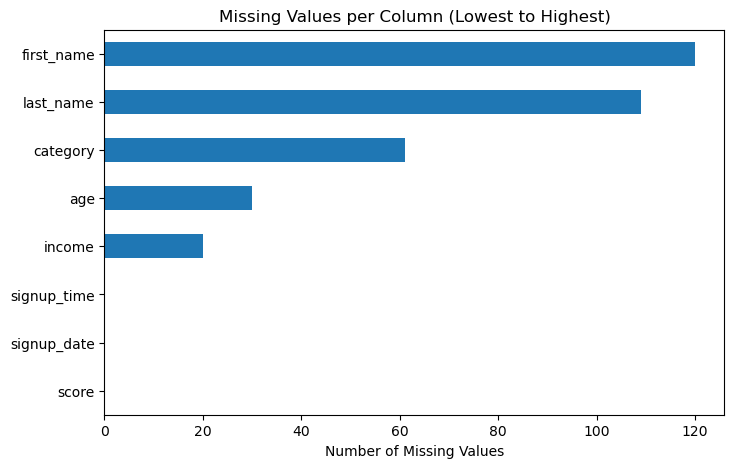

In [111]:
# Print count of missing values per column
print(f"\nMissing values per column:\n{df_trashy_dataset.isna().sum()}")

# Visualize missing values as a bar plot
missing_counts = df_trashy_dataset.isna().sum().sort_values()
plt.figure(figsize=(8, 5))
ax = missing_counts.plot(kind='barh')
plt.xlabel('Number of Missing Values')
plt.title('Missing Values per Column (Lowest to Highest)')
plt.show()

In [112]:
# Fill missing values with column means (numeric) or mode (categorical)
df_fillna = df_trashy_dataset.copy()
print(df_fillna.describe(include='all'), end='\n\n')


# Criteria for filling in missing values for each column:
for col in df_fillna.columns:
    if df_fillna[col].dtype in [np.float64, np.int64]:          # Numeric Columns - Fill with Mean
        mean_value = df_fillna[col].mean()
        df_fillna[col] = df_fillna[col].fillna(mean_value)
    elif df_fillna[col].dtype == 'object':                      # Categorical Columns - Fill with most frequent (mode)
        mode_value = df_fillna[col].mode()[0]
        df_fillna[col] = df_fillna[col].fillna(mode_value)
    elif np.issubdtype(df_fillna[col].dtype, np.datetime64):    # Datetime Columns - Fill with most frequent (mode)
        mode_value = df_fillna[col].mode()[0]
        df_fillna[col] = df_fillna[col].fillna(mode_value)

# View summary statistics
df_fillna.info()

# View DataFrame after filling missing values
print(df_fillna.loc[404])


       first_name last_name         age         income       score  \
count         390       401  480.000000     490.000000  510.000000   
unique          7         7         NaN            NaN         NaN   
top          Bob        DOE         NaN            NaN         NaN   
freq           62        69         NaN            NaN         NaN   
mean          NaN       NaN   52.712500   51436.949471   50.696396   
std           NaN       NaN   21.531951   21355.627530   31.370096   
min           NaN       NaN   15.000000    5532.067432  -10.000000   
25%           NaN       NaN   35.000000   39996.109592   22.341858   
50%           NaN       NaN   52.000000   50806.316997   49.246476   
75%           NaN       NaN   72.000000   60437.522114   77.046563   
max           NaN       NaN   89.000000  214623.552635  150.000000   

       signup_date signup_time category  
count          510         510      449  
unique         500         500        3  
top     2020/03/14       09:13   

In [113]:
# Use dropna() to get rid of rows where any column is NaN/Null
df_dropna = df_trashy_dataset.copy()
df_dropna = df_dropna.dropna(how='any')

# View summary statistics
print(f'New Shape: {df_dropna.shape}\n')
df_dropna.info()

# Why do we still see indexes 0-499?

New Shape: (242, 8)

<class 'pandas.core.frame.DataFrame'>
Index: 242 entries, 2 to 509
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   first_name   242 non-null    object 
 1   last_name    242 non-null    object 
 2   age          242 non-null    float64
 3   income       242 non-null    float64
 4   score        242 non-null    float64
 5   signup_date  242 non-null    object 
 6   signup_time  242 non-null    object 
 7   category     242 non-null    object 
dtypes: float64(3), object(5)
memory usage: 17.0+ KB


## 4. Quick Transformations
- Types: `df['col'] = df['col'].astype('Int64')`, `to_datetime`, `to_numeric(errors='coerce')`
- String cleanup: `str.strip()`, `str.lower()`, `str.replace()`
- Column ops: `rename`, `assign`, `eval`
- Split/merge: `merge`, `join`, `concat`
- Grouped summaries: `groupby(...).agg({'col':['count','mean','median']})`

> Exercise: normalize a numeric column to [0,1] using min-max, then compute per-group means.

In [119]:
df_transformed = df_dropna.copy()
df_transformed.head()

,first_name,last_name,age,income,score,signup_date,signup_time,category
2,ALICE,Brown,73.0,26547.830782,61.048507,2021/04/20,15:55,C
4,steve,jones,16.0,58070.516599,67.226443,2021_01_03,14:08,C
5,mary,SMITH,18.0,54439.909845,59.571377,2020/02/25,08:55,B
6,mary,DOE,61.0,38516.970839,25.780841,2020/11/18,13:22,B
10,john,Wilson,65.0,36964.291282,39.850662,2021/02/19,14:55,B


In [120]:
# Enforce column datatypes
df_transformed['first_name'] = df_transformed['first_name'].astype('string')
df_transformed['last_name'] = df_transformed['last_name'].astype('string')
df_transformed['age'] = df_transformed['age'].astype('int')

# Clean and standardize text columns
df_transformed['first_name'] = df_transformed['first_name'].str.strip().str.title()
df_transformed['last_name'] = df_transformed['last_name'].str.strip().str.title()

# Round income and score to 2 decimal places
df_transformed['income'] = df_transformed['income'].round(2)
df_transformed['score'] = df_transformed['score'].round(2)

df_transformed.head()

,first_name,last_name,age,income,score,signup_date,signup_time,category
2,Alice,Brown,73,26547.83,61.05,2021/04/20,15:55,C
4,Steve,Jones,16,58070.52,67.23,2021_01_03,14:08,C
5,Mary,Smith,18,54439.91,59.57,2020/02/25,08:55,B
6,Mary,Doe,61,38516.97,25.78,2020/11/18,13:22,B
10,John,Wilson,65,36964.29,39.85,2021/02/19,14:55,B


In [124]:
# Standardized date and time columns
df_transformed['signup_date'] = pd.to_datetime(df_transformed['signup_date'], errors='coerce')
df_transformed.head()

,first_name,last_name,age,income,score,signup_date,signup_time,category
2,Alice,Brown,73,26547.83,61.05,2021-04-20,15:55,C
4,Steve,Jones,16,58070.52,67.23,2021-01-03,14:08,C
5,Mary,Smith,18,54439.91,59.57,2020-02-25,08:55,B
6,Mary,Doe,61,38516.97,25.78,2020-11-18,13:22,B
10,John,Wilson,65,36964.29,39.85,2021-02-19,14:55,B


In [129]:
# Use regex to replace non-digit characters with '-' before parsing
df_transformed["signup_date"] = df["signup_date"].str.replace(r"\D", "/", regex=True)
df_transformed["signup_date"] = pd.to_datetime(df_transformed["signup_date"], errors="coerce")
df_transformed.head()


,first_name,last_name,age,income,score,signup_date,signup_time,category
2,Alice,Brown,73,26547.83,61.05,2021-04-20,15:55,C
4,Steve,Jones,16,58070.52,67.23,2021-01-03,14:08,C
5,Mary,Smith,18,54439.91,59.57,2020-02-25,08:55,B
6,Mary,Doe,61,38516.97,25.78,2020-11-18,13:22,B
10,John,Wilson,65,36964.29,39.85,2021-02-19,14:55,B


## 5. Validations (cheap but effective)
- Range checks: `(df['age']>=0) & (df['age']<=120)`
- Cross-field rules: if `end_time` then `end_time>=start_time`
- Uniqueness: `df['id'].is_unique`
- Duplicates: `df.duplicated(subset=[...], keep=False)` then review

> Exercise: write 3 boolean checks and compute the percent of rows failing each.

## 6. Export
- Save a clean slice: `df.to_parquet('clean.parquet', index=False)` or `to_csv`
- Document assumptions in a README cell or a sidecar `.md` file.

**Takeaways**
- Start with discovery, not modeling.
- Make missingness visible first, then pick the simplest plausible fix.
- Encode your checks so you can re-run them later.